In [5]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> h w (b c)").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def experiment(config, x):

    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("denoising")
    axs[1].imshow(plotable(x_tilde))
    axs[2].set_title("estimation")
    axs[2].imshow(plotable(x_hat))
    plt.show()

In [6]:
model_name = "celeba/gan/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)
gen = iter(dm)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
from data import  CelebADataModule
import torchvision.transforms as transforms

bs = 1
IMAGE_SIZE = 64
CROP = 128
lr = 1e-3
epochs= 1
latent_dim = 256
DATA_PATH = "kaggle"

trans = []
trans.append(transforms.RandomHorizontalFlip())
if CROP > 0:
  trans.append(transforms.CenterCrop(CROP))
trans.append(transforms.Resize(IMAGE_SIZE))
trans.append(transforms.ToTensor())
transform = transforms.Compose(trans)

dm = CelebADataModule(data_dir=DATA_PATH,
                            target_type='attr',
                            train_transform=transform,
                            val_transform=transform,
                            download=True,
                            batch_size=bs)

dm.prepare_data() # force download now
dm.setup() # force make data loaders n

batch = next(iter(dm.train_dataloader()))
x, y = batch 

  0%|          | 5.00M/1.33G [00:00<00:35, 39.7MB/s]

100%|██████████| 1.33G/1.33G [00:45<00:00, 31.3MB/s]


100%|██████████| 2.02M/2.02M [00:00<00:00, 67.9MB/s]


100%|██████████| 1.54M/1.54M [00:00<00:00, 44.9MB/s]


100%|██████████| 466k/466k [00:00<00:00, 51.9MB/s]


100%|██████████| 2.07M/2.07M [00:00<00:00, 45.9MB/s]


Done!



/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [39]:
batch = next(iter(dm.train_dataloader()))
x, y = batch 

In [53]:
config["operator_params"]["operator"] = "CenterOcclude"
config["operator_params"]["noise_level"] = 0.01
config["operator_params"]["num_measurements"] = 1000
config["operator_params"]["lambda"] = 10

In [54]:
config["base_model_params"]["base_model"] = "gan"
config["estimator_params"]["n_samples"] = 1500
config["estimator_params"]["burn_in"] = 0

In [55]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
    num_measurements: 1000
    noise_level: 0.01
    lambda: 10
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 1500
    step_size: 0.01
    lambda: 1
    mode: avg
    noise_factor: 0.5
    initalisation: posterior
    potential: mse
base_model_params
    model_name: celeba/vae/vqvae
    base_model: gan


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


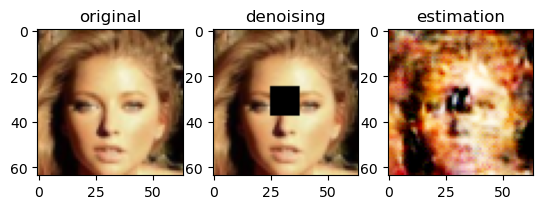

In [56]:
experiment(config, x)